Captura en video

In [ ]:
import cv2
import mediapipe as mp
import torch
import numpy as np
from torchvision import transforms
from torchvision.models import resnet18
import torch.nn as nn

# Definición del modelo
class SignLanguageModel(nn.Module):
    def __init__(self):
        super(SignLanguageModel, self).__init__()
        self.base_model = resnet18(pretrained=True)
        self.base_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, 29)
    
    def forward(self, x):
        return self.base_model(x)

# Cargar el modelo entrenado
model = SignLanguageModel()
model.load_state_dict(torch.load('modelo_final.pth', map_location=torch.device('cpu')))
model.eval()

# MediaPipe para detección de manos
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

def get_hand_bounding_box(image, hand_landmarks):
    h, w, _ = image.shape
    x_min, y_min = w, h
    x_max, y_max = 0, 0
    
    for lm in hand_landmarks.landmark:
        x, y = int(lm.x * w), int(lm.y * h)
        if x < x_min:
            x_min = x
        if y < y_min:
            y_min = y
        if x > x_max:
            x_max = x
        if y > y_max:
            y_max = y

    return (x_min, y_min, x_max, y_max)

# Transformaciones de imagen
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((100, 100)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Lista de etiquetas para las clases
labels = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ") + ["nothing", "space"]

# Umbral de confianza
confidence_threshold = 0.7

# Capturar y procesar imágenes de la cámara web
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    # Convertir la imagen a RGB
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Detectar manos en la imagen
    with mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.5) as hands:
        results = hands.process(image)
    
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                # Obtener el cuadro delimitador de la mano
                bbox = get_hand_bounding_box(image, hand_landmarks)
                
                # Verificar si el cuadro delimitador está dentro de los límites de la imagen
                if bbox[0] < 0 or bbox[1] < 0 or bbox[2] > image.shape[1] or bbox[3] > image.shape[0]:
                    continue

                # Recortar la imagen de la mano
                hand_image = image[bbox[1]:bbox[3], bbox[0]:bbox[2]]

                # Verificar si el tamaño de la imagen recortada es mayor que cero
                if hand_image.size == 0:
                    continue

                hand_image = cv2.resize(hand_image, (100, 100))  # Match the input size of the model
                hand_image = cv2.cvtColor(hand_image, cv2.COLOR_RGB2GRAY)  # Convertir a escala de grises
                hand_image = hand_image / 255.0
                hand_image = np.expand_dims(hand_image, axis=0)
                hand_image = np.expand_dims(hand_image, axis=0)
                
                with torch.no_grad():
                    input_tensor = torch.tensor(hand_image, dtype=torch.float32)
                    output = model(input_tensor)
                    _, predicted = torch.max(output, 1)
                    class_id = predicted.item()
                    confidence = torch.softmax(output, 1)[0, class_id].item()
                
                # Verificar que class_id esté dentro del rango de classes
                if class_id < len(labels):
                    letter = labels[class_id]
                else:
                    print(f'Error: class_id {class_id} está fuera del rango de la lista labels.')
        
                # Mostrar el resultado solo si la confianza es alta
                if confidence >= confidence_threshold:
                    cv2.putText(frame, f'Letter: {letter}, Confidence: {confidence:.2f}', (bbox[0], bbox[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
                    cv2.rectangle(frame, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)
    
    # Mostrar la imagen
    cv2.imshow('Hand Sign Detection', frame)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


Prediccion de una sola foto:

La foto se capturará en 3 segundos
3
2
1
Foto tomada


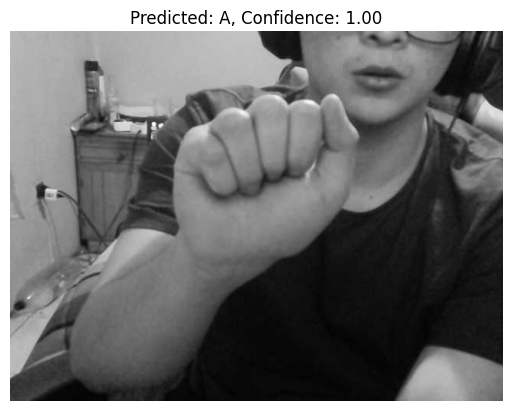

In [8]:
import cv2
import mediapipe as mp
import torch
import numpy as np
from torchvision import transforms
from torchvision.models import resnet18
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
import time

# Definición del modelo
class SignLanguageModel(nn.Module):
    def __init__(self):
        super(SignLanguageModel, self).__init__()
        self.base_model = resnet18(pretrained=True)
        self.base_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, 29)
    
    def forward(self, x):
        return self.base_model(x)

# Cargar el modelo entrenado
model = SignLanguageModel()
model.load_state_dict(torch.load('modelo_final.pth', map_location=torch.device('cpu')))
model.eval()

# MediaPipe para detección de manos
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

def get_hand_bounding_box(image, hand_landmarks):
    h, w, _ = image.shape
    x_min, y_min = w, h
    x_max, y_max = 0, 0
    
    for lm in hand_landmarks.landmark:
        x, y = int(lm.x * w), int(lm.y * h)
        if x < x_min:
            x_min = x
        if y < y_min:
            y_min = y
        if x > x_max:
            x_max = x
        if y > y_max:
            y_max = y

    return (x_min, y_min, x_max, y_max)

# Transformaciones de imagen
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((100, 100)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Lista de etiquetas para las clases
labels = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ") + ["nothing", "space"]

# Umbral de confianza
confidence_threshold = 0.80

def capture_image():
    print("La foto se capturará en 3 segundos")
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Error: No se puede abrir la cámara.")
        return None

    for i in range(3, 0, -1):
        print(i)
        time.sleep(1)

    ret, frame = cap.read()
    if not ret:
        print("Error: No se puede leer la imagen de la cámara.")
        cap.release()
        return None

    print("Foto tomada")
    # Guardar la imagen capturada temporalmente
    image_path = 'captured_image.png'
    cv2.imwrite(image_path, frame)

    # Liberar la cámara
    cap.release()
    cv2.destroyAllWindows()
    return image_path

def detect_hand_and_predict(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    with mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5) as hands:
        results = hands.process(image_rgb)
    
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                # Obtener el cuadro delimitador de la mano
                bbox = get_hand_bounding_box(image_rgb, hand_landmarks)
                
                # Verificar si el cuadro delimitador está dentro de los límites de la imagen
                if bbox[0] < 0 or bbox[1] < 0 or bbox[2] > image.shape[1] or bbox[3] > image.shape[0]:
                    continue

                # Recortar la imagen de la mano
                hand_image = image[bbox[1]:bbox[3], bbox[0]:bbox[2]]

                # Verificar si el tamaño de la imagen recortada es mayor que cero
                if hand_image.size == 0:
                    continue

                hand_image = cv2.resize(hand_image, (100, 100))  # Match the input size of the model
                hand_image = cv2.cvtColor(hand_image, cv2.COLOR_RGB2GRAY)  # Convertir a escala de grises
                hand_image = hand_image / 255.0
                hand_image = np.expand_dims(hand_image, axis=0)
                hand_image = np.expand_dims(hand_image, axis=0)
                
                # Volver a predecir hasta obtener una confianza alta
                while True:
                    with torch.no_grad():
                        input_tensor = torch.tensor(hand_image, dtype=torch.float32)
                        output = model(input_tensor)
                        _, predicted = torch.max(output, 1)
                        class_id = predicted.item()
                        confidence = torch.softmax(output, 1)[0, class_id].item()
                    
                    # Verificar que class_id esté dentro del rango de classes
                    if class_id < len(labels):
                        letter = labels[class_id]
                    else:
                        print(f'Error: class_id {class_id} está fuera del rango de la lista labels.')

                    if confidence >= confidence_threshold:
                        # Mostrar el resultado solo si la confianza es alta
                        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                        image_rgb_gray = cv2.cvtColor(image_gray, cv2.COLOR_GRAY2RGB)
                        plt.imshow(image_rgb_gray, cmap='gray')
                        plt.title(f'Predicted: {letter}, Confidence: {confidence:.2f}')
                        plt.axis('off')
                        plt.show()
                        break

def main():
    # Capturar la imagen
    image_path = capture_image()
    if image_path is None:
        return

    # Detectar mano y predecir
    detect_hand_and_predict(image_path)

if __name__ == "__main__":
    main()
